# What is Machine Learning?

### Machine Learning Paradigms
- Supervised learning
- Unsupervised learning
- Reinforcement learning



# Supervised Learning

- Predict something given some data


## Inputs  

- Data you want to learn a representation of
- The input data can be viewed as a spreadsheet
    - Each row is a single input to our model
    - An input is composed of a set of features (columns in the spreadsheet)
   


## Targets
- What are we trying to predict?
- A target represents the ideal output of a model for a given input
- Commonly stored as the last column

<br/> 
<br/> 

| Height | Weight | Gender | Age | Smokes | % chance of developing heart disease over next yr |
| --- | --- | --- | --- | --- | --- |
| 71 | 165 | 1 | 27 | 0 | 0.053 |
| 64 | 137 | 0 | 41 | 1 | 0.170 |

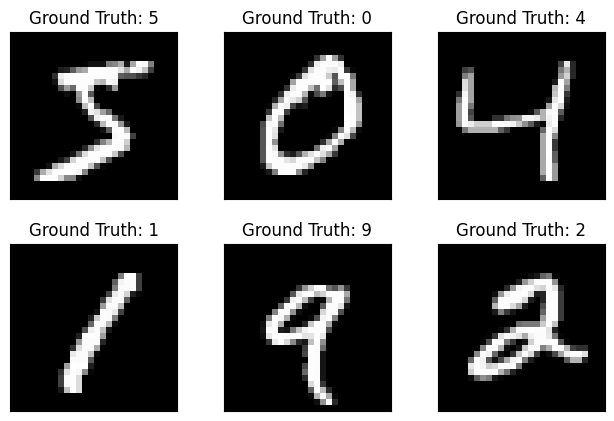

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnistDataset = datasets.MNIST('./data', train=True, download=True, 
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ]))

mnistExample = DataLoader(mnistDataset, batch_size=6)
batchIdx, (exampleInput, exampleTargets) = next(enumerate(mnistExample))
exampleData = exampleInput#.detach().numpy().squeeze()
#plt.imshow(exampleData, cmap='gray')
#plt.show()

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(exampleTargets[i]))
    plt.xticks([])
    plt.yticks([])



### A, b, c, d... 

- $x$ collection of input data, a vector of vectors 
    - $x_i$ individual sample of $x$
        - a vector whose size is equal to the number of features being used
- $n$ number of samples
- $f$ model (function)
- $y$ collection of targets/labels, the desired output for each sample in $x$
    - Ground truth label  
- $\hat{y}$ output of our model (y-hat)  
    


### Representations

- The goal of our model is to learn a representation of $ f(x) = y $
- The actual output of our model: $f(x) = \hat{y}$
- The ideal:
    - For each individual vector $x_i$ give us an output $\hat{y_i}$ that is as close to the ground truth $y_i$ as possible
    - $\forall{x_i} \in \: x,\space f(x_i) = \hat{y_i} = y_i$ 

### Neural Network

- For a fully connected feed forward nueral network...
    - Composed of layers of neurons
    - Adjacent layer neurons always connected
    - output size depends on target


<img src="images/A-fully-connected-neural-network-with-two-hidden-layers.png" width="400">


### Layers

- Composed of a number of neurons
- For every connection, there is a weight $w$
- $w^k_{ij} \in \mathbb{R}$
    - $i$ index of input
    - $j$ index of neuron
    - $k$ index of layer


### Neurons

<img src="images/neuron.png" width="400">


### Neurons2

- Layers of a network are composed of neurons
- In a fully connected network, each neuron from $layer_k$ gives its output to each neuron in $layer_{k+1}$
- A neuron has $n$ inputs
- Activation function $\phi$
- For $neuron_j$
    - Each input $x_i$ has an associated weight $w_{ij} \in \mathbb{R}$
    - Net input $z_j = net_j = \sum_{i=1}^{n}x_i w_{ij}$
    - The output $\phi(z_j) = o_j$



### Activation Functions

- Simulate the on/off firing of a biological neuron  

- Must have a derivative at all points*
- Sigmoid
    - $\phi(z) = \frac{1}{1 + e^{-z}}$
    
    - $\phi'(z) = \phi(z)(1-\phi(z))$
- ReLU
    - $\phi(z) = maz(0, z)$

    - $\phi'(z) = z > 0 \ ? \ 1 : 0$
    - *not differentiable at $0$ so derivative @ $0$ is usually set to $0$ or $1$
- Linear
    - $\phi(z) = mz + b \equiv I(z)$  
    - not useful for MLP's
    


#### Sigmoid
<img src="images/sigmoid.png" width="400">

#### ReLU
<img src="images/relu.png" width="400">

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

batchSize = 32
train_loader = DataLoader(mnistDataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(mnistDataset, batch_size=batchSize, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        return F.log_softmax(x, dim=1)
    
network = Net()
print(network)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
)


In [3]:
import os
def saveNetwork(network, optimizer, modelName, epoch):
    if not os.path.exists(f'results/{modelName}'):
        os.makedirs(f'results/{modelName}')
    torch.save(network.state_dict(), f'results/{modelName}/{epoch}-model.pth')
    torch.save(optimizer.state_dict(), f'results/{modelName}/{epoch}-optim.pth')

log_interval = 10
def batchWork(network, optimizer, modelName, batch_idx, epoch, loss, train_losses, train_counter, printBatchInfo):   
    if printBatchInfo:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(x), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_counter.append(
        (batch_idx*batchSize) + ((epoch-1)*len(train_loader.dataset)))
    saveNetwork(network, optimizer, modelName, epoch)

In [4]:
lr = 0.001
optimizer = optim.SGD(network.parameters(), lr=lr)
lossFn = nn.CrossEntropyLoss()

epochs = 4
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, modelName, printBatchInfo = False):
    network.train()
    for batch_idx, (x, y) in enumerate(train_loader):
        optimizer.zero_grad()

        output = network(x)
        loss = lossFn(output, y)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            batchWork(network, optimizer, modelName, batch_idx, 
                      epoch, loss, train_losses, train_counter, printBatchInfo)

#for epoch in range(1, 2):
#    train(epoch, modelName='tmpModel', printBatchInfo=True)


#### Example batch training output
```
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.334714
Train Epoch: 1 [280/60000 (1%)]	Loss: 1.131673
Train Epoch: 1 [560/60000 (1%)]	Loss: 0.775013
Train Epoch: 1 [840/60000 (2%)]	Loss: 0.521945
Train Epoch: 1 [1120/60000 (2%)]	Loss: 0.847648
Train Epoch: 1 [1400/60000 (3%)]	Loss: 0.495903
Train Epoch: 1 [1680/60000 (3%)]	Loss: 0.422707
Train Epoch: 1 [1960/60000 (4%)]	Loss: 0.784840
Train Epoch: 1 [2240/60000 (4%)]	Loss: 0.450909
Train Epoch: 1 [2520/60000 (5%)]	Loss: 0.247951
Train Epoch: 1 [2800/60000 (5%)]	Loss: 0.739784
```

In [5]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for x, y in test_loader:
            output = network(x)
            test_loss += lossFn(output, y).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(y.data.view_as(pred)).sum() 
    
        test_loss /= len(test_loader.dataset) / batchSize
        test_losses.append(test_loss)
        print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        
test()
for epoch in range(1, epochs + 1):
    train(epoch, modelName = 'fc_768_128_10', printBatchInfo=False)
    test()



Test set: Avg. loss: 2.2975, Accuracy: 9116/60000 (15%)


Text(0, 0.5, 'cross-entropy loss')

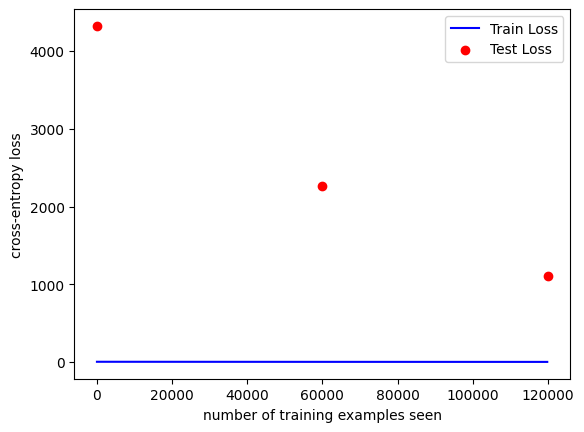

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('cross-entropy loss')

### Error / Loss

- How inaccurate is our model?
- Your error function must be differentiable

- $E = MAE = \dfrac{|\hat{y} - y|}{n} = \dfrac{\sum_{i}^{n}{|\hat{y}_i - y_i|}}{n} = L1$

- $E = MSE = \dfrac{(\hat{y} - y)^2}{n} = \dfrac{\sum_{i}^{n}{(\hat{y}_i - y_i)^2}}{n} = L2$
- Ex:
    - $y = [1, 2, 3]$
    - $\hat{y} = [7, 2, -2]$
    
    - $MAE = \dfrac{(7-1)+(2-2)+(-2-3)}{3}$

### Gradient Descent

- Algorithm for finding a local minimum of a differentiable function
- Allows for us to find a minimum based on our cost function $C(x)$ 
- Find the gradient by taking the derivitive of a function
    - The gradient represents the direction in which change is the greatest
    - For us the gradient of $C(x)$ 
- Make a step in the opposite direction of the gradient

- $$

<img src="images/non-convex-sgd.jpg" width="506">




<img src="images/global_min_1.png" width="600">

### Overview

1. Determine what the input data for the model will be
2. Build training dataset
    - inputs & target/label for each sample
3. Determine what type of learning model to use & the structure of it
    - NN, Random Forest, Gradient Boost, etc.
4. Set hyperparameters & run the model over the training set
    - Usually model will process the training set in batches of samples
    - Walk the model down the optimization landscape
5. Determine accuracy of model/function on the so far unused test-set data